                                                  Class: Statistical Learning Methods, Warsaw School Of Economics
                                                  Date: 2021-05-31 [update: 2022-11]
                                                  Author: Joanna Koła
                                                  Data: https://archive.ics.uci.edu/ml/dataset/Bank+Marketing


# Influence of marketing on term deposits subscriptions 

The dataset consists of the following attributes:

* ***Client personal information:*** age, job, marital status, education level
* ***Previous client credit history:*** if client has credit in default(default), housing loan(housing) or personal loan (loan)
* ***Related with the campaign:*** contact communication type (contact), last contact month of year(month), last contact day of the week (day_of_week), last contact duration (duration), number of contacts performed during this campaign and for this client(campaign), number of days that passed by after the client was last contacted from a previous campaign (pdays), number of contacts performed before this campaign (previous), outcome of the previous marketing campaign (poutcome)
* ***Social and economic context attributes:*** quarterly indicator of employment variation rate (emp.var.rate),  monthly indicator of consumer price index (cons.price.idx), consumer confidence index (cons.conf.idx), daily indicator of euribor 3 month rate (euribor3m), quarterly indicator of number of employees (nr.employed)
* ***Group flag*** - campaign group or control group

Dataset consists of:

* 21 variables
* target variable (if client placed a term deposit or not).

The aim of the following analysis will be to identify customers for whom the gain from being contacted is the highest and to assess how much profit for the bank the next wave of campaigns will bring.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import random
import warnings

from scipy import stats
from imblearn.over_sampling import SMOTE
import scikitplot as skplt

from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

import scikitplot as skplt

import warnings
warnings.filterwarnings("ignore")
random.seed(11)

In [2]:
df = pd.read_csv('bank_data_prediction_task.csv', index_col=0)

# Informations about the campaign

As can be seen from the bar chart, there is only a slight difference between clients that were subjects of the campaign and the control group. However, before, analysis methods were not used, which may have been the cause of such a bad outcome. We can also see that, in general, approximately 15% of respondents of the campaign placed the deposits and 10% of clients from the control group did the same. This means that:
* **the placement of deposits after campaign was 1.5 times higher than without it**
* **40% of clients were included in the campaign**

In [3]:
def show_categories_bar_chart(x, y, dataset):
    (dataset.groupby(x)[y].value_counts(
        normalize=True).mul(100).rename('percent').reset_index().pipe(
            (sns.catplot, 'data'),
            x=x,
            y='percent',
            hue=y,
            palette="ch:.25",
            height=4,
            aspect=12 / 4,
            kind='bar'))

In [4]:
groups_counts = df['test_control_flag'].value_counts()

print("Total number of clients in control group: {}".format(groups_counts[0]))
print("Total number of clients in campaign group: {}".format(groups_counts[1]))
print("What percentage of clients is taken into campaign: {} %".format(
    round(groups_counts[1] / (groups_counts[0] + groups_counts[1]), 2) *100))

Total number of clients in control group: 24712
Total number of clients in campaign group: 16476
What percentage of clients is taken into campaign: 40.0 %


Percentage of clients in the control group who placed a deposit 15.08 %
Percentage of clients in the campaign group who placed a deposit 10.86 %


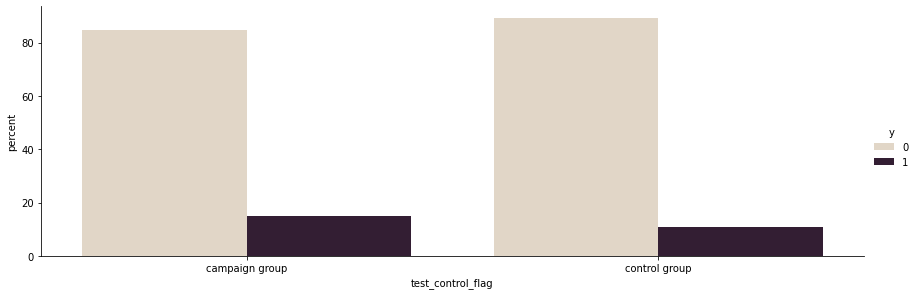

In [42]:
# changing y into 0-1 variable
df['y'].replace('yes', 1, inplace=True)
df['y'].replace('no', 0, inplace=True)

populations = [i[1] for i in df.groupby(["test_control_flag"])['y'].count().reset_index().values]
ys = [i[1] for i in df.groupby(["test_control_flag"])['y'].sum().reset_index().values]

print("Percentage of clients in the control group who placed a deposit {} %".
      format(round(ys[0] / populations[0] * 100, 2)))
print("Percentage of clients in the campaign group who placed a deposit {} %".
      format(round(ys[1] / populations[1] * 100, 2)))

show_categories_bar_chart('test_control_flag', 'y', df)

The aim of this analysis is to create a model that will be able to predict the success of future campaigns for a client. This means that ***only features that are known before the campaign might be used to build the model***. This means that only features like the ones below might be used for building the model:

* age, job, marital status, education level
* if client has credit in default(***default***), housing loan(***housing***) or personal loan (***loan***)
* number of days that passed by after the client was last contacted from a previous campaign (***pdays***), number of contacts performed before this campaign (***previous***), outcome of the previous marketing campaign (***poutcome***)
* quarterly indicator of employment variation rate (***emp.var.rate***),  monthly indicator of consumer price index (***cons.price.idx***), consumer confidence index (***cons.conf.idx***), daily indicator of euribor 3 month rate (***euribor3m***), quarterly indicator of number of employees (***nr.employed***)

Features that can be only used during EDA to obtain some insights that could improve our campaign:

* contact communication type (***contact***), last contact month of year(**month**), last contact day of the week (**day_of_week**), last contact duration (**duration**), number of contacts performed during this campaign and for this client(**campaign**)

# Loking for missing values #

After looking for missing values, I have concluded that almost 3/4 of the dataset rows have missing values. Removing them in this case would be unacceptable. It will be necessary to deal with them in other ways.

In [6]:
print("Number of rows with missing values: " + str(len(df[df.apply(lambda x: x.str.contains('unknown').any()
                                                                   or pd.isna(x).any(), axis=1)])))
df_temp = df.replace(r"unknown", np.nan, inplace=False)
df_temp.info()

Number of rows with missing values: 28946
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 1 to 41188
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                41188 non-null  int64  
 1   job                40858 non-null  object 
 2   marital            41108 non-null  object 
 3   education          39457 non-null  object 
 4   default            32591 non-null  object 
 5   housing            40198 non-null  object 
 6   loan               40198 non-null  object 
 7   contact            16476 non-null  object 
 8   month              16476 non-null  object 
 9   day_of_week        16476 non-null  object 
 10  duration           16476 non-null  float64
 11  campaign           16476 non-null  float64
 12  pdays              41188 non-null  int64  
 13  previous           41188 non-null  int64  
 14  poutcome           41188 non-null  object 
 15  emp.var.rate       41188 non

For such variables like job and education, missing values are probably not random (people tend to avoid saying when they are unemployed or do not have any education). When it comes to 8–12 variables, they are all related to the campaign, so a lack of them probably indicates that the marketing campaign was not conducted on them, so they are control group (test_control_flag='control_group'). 

I made a decision to treat particular variables with lacks of data in this manner:
- ***job, education, default, housing, loan , contact, month, day_of_week*** - I will change all nans into 'unknown' and keep it as a separate category. I will ***treat lack of value as a value itself***
- ***duration, campaign*** -  I will ***set lacks to 0***
- ***cons.price.idx*** - I will ***use Nearest Neighbours algorithm***, taking into consideration observations with similar values of emp.var.rate, cons.conf.idx and  euribor3m.

In [7]:
df[[
    'job', 'education', 'default', 'housing', 'loan', 'contact', 'month',
    'day_of_week'
]] = df[[
    'job', 'education', 'default', 'housing', 'loan', 'contact', 'month',
    'day_of_week'
]].fillna('unknown')

df[['duration', 'campaign']] = df[['duration', 'campaign']].fillna(0)

In [8]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights="uniform")
X = df[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']]
# obtaining dataframe with imputed cons.price.idx
df_imputer = pd.DataFrame(imputer.fit_transform(X), columns=df.columns[16:20])
# swaping old cons.price.idx to cons.price.idx with no missings
df['cons.price.idx'] = df_imputer['cons.price.idx'].values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 1 to 41188
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                41188 non-null  int64  
 1   job                41188 non-null  object 
 2   marital            41188 non-null  object 
 3   education          41188 non-null  object 
 4   default            41188 non-null  object 
 5   housing            41188 non-null  object 
 6   loan               41188 non-null  object 
 7   contact            41188 non-null  object 
 8   month              41188 non-null  object 
 9   day_of_week        41188 non-null  object 
 10  duration           41188 non-null  float64
 11  campaign           41188 non-null  float64
 12  pdays              41188 non-null  int64  
 13  previous           41188 non-null  int64  
 14  poutcome           41188 non-null  object 
 15  emp.var.rate       41188 non-null  float64
 16  cons.price.idx     411

# Exploratory data analysis and looking for outliers

## Unbalanced dataset

Another important observation is the fact that the dependent variable is very unbalanced. 90% of observations are for respondents who did not subscribe to a deposit. It will be taken into account while training the model.

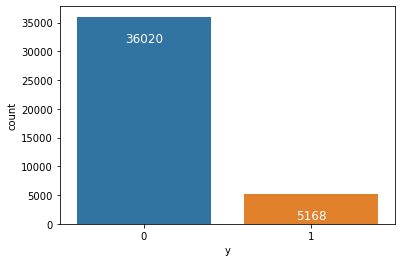

In [61]:
ax = sns.countplot(x="y", data=df)
for p in ax.patches:
     ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)

## Outliers - numerical

To find outliers, I've used ***statistic Z*** (z = (X — mean) / std_deviation) with the assumption that every observation with z-score higher than 3 or smaller than -3 is may be an outlier. I used the ***describe function*** to look into quantiles and min-max. Then I decided to transform three variables into ***logarithms***:


* ***age*** - but value of age shouldn't be considered as outlier, as we can see that minimal age in dataset is 17, while maximal 95
* ***pdays*** - it is the number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted).  Moreover, we can see that most values of this variable is 999 (first quantile is already 999).
* ***previous*** - which means number of contacts performed before this campaign and for this client. Again all quantiles are zeros.


Two other features have highly skewed distributions. ***However, these features will not be used for model so I will leave it this way***:

* ***campaign*** - number of contacts performed during this campaign and for this client. All quantiles are zeros. 
* ***duration*** - last contact duration



In [11]:
treshold = 3
df_quant_outliers = pd.DataFrame.from_records(
    stats.zscore(df.select_dtypes(include=np.number)),
    columns=df.select_dtypes(include=np.number).columns.tolist())

print("Number of outliers per attribute:")
print(df_quant_outliers[(df_quant_outliers > treshold) | (df_quant_outliers < -treshold)].count())
outlier_list = list(
    np.where((df_quant_outliers > treshold) | (df_quant_outliers < -treshold))[0])

Number of outliers per attribute:
age                369
duration           890
campaign           699
pdays             1515
previous          1064
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64


In [12]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000
mean,40.02406,103.86911,1.01879,962.47545,0.17296,0.08189,0.08189,-40.50260,3.62129,5167.03591,0.12547
std,10.42125,208.23106,2.11474,186.91091,0.49490,1.57096,1.57096,4.62820,1.73445,72.25153,0.33126
min,17.00000,0.00000,0.00000,0.00000,0.00000,-3.40000,-3.40000,-50.80000,0.63400,4963.60000,0.00000
25%,32.00000,0.00000,0.00000,999.00000,0.00000,-1.80000,-1.80000,-42.70000,1.34400,5099.10000,0.00000
50%,38.00000,0.00000,0.00000,999.00000,0.00000,1.10000,1.10000,-41.80000,4.85700,5191.00000,0.00000
75%,47.00000,139.00000,1.00000,999.00000,0.00000,1.40000,1.40000,-36.40000,4.96100,5228.10000,0.00000
max,98.00000,4918.00000,43.00000,999.00000,7.00000,1.40000,1.40000,-26.90000,5.04500,5228.10000,1.00000


In [13]:
df['log_age'] = df['age'].map(lambda x: np.log(x + 1))
df['log_previous'] = df['previous'].map(lambda x: np.log(x + 1))
df['pdays'] = df['previous'].map(lambda x: np.log(x + 1))
df.drop("age", axis='columns', inplace=True)
df.drop("previous", axis='columns', inplace=True)
df.drop('pdays', axis='columns', inplace=True)

## Outliers - categorical

Next, I wanted to look into categorical variables. As a result, I'll join some categories, because otherwise the number of dummies introduced later would be far too large.

In [14]:
d = {'attribute': [], 'least_common_value': [], 'count': []}
least_common_tab = pd.DataFrame(data=d)

for col_name in df.select_dtypes(include='object').columns:
    top_down_row = pd.DataFrame(df[col_name].value_counts()).iloc[[-1]]
    d['attribute'].append(top_down_row.columns[0])
    d['least_common_value'].append(top_down_row.index[0])
    d['count'].append(top_down_row.iloc[0, 0])

least_common_tab = pd.DataFrame(data=d)
least_common_tab

,attribute,least_common_value,count
0,job,unknown,330
1,marital,unknown,80
2,education,illiterate,18
3,default,yes,3
4,housing,unknown,990
5,loan,unknown,990
6,contact,telephone,5995
7,month,dec,78
8,day_of_week,fri,3111
9,poutcome,success,1373


In [15]:
# Joining categories 
# for this point also catplots from next section were analysed
df['credit'] = df[['loan', 'housing', 'default']].apply(lambda x: x.str.contains('yes').any(), axis=1)
df['education'] = df['education'].replace(['basic.4y','basic.6y','basic.9y',"illiterate"],'basic')
df['education'] = df['education'].replace(['basic','high.school','professional.course'],'non-graduate')
df['job'] = df['job'].replace(['student','unemployed','retired'],'unemployed')
df['job'] = df['job'].replace(['self-unemployed', 'entrepreneur'],'self-employed')
df['job'] = df['job'].replace(['management','admin.'],'management and admin')
df['job'] = df['job'].replace(['blue-collar','services','management job'],'office')
df['job'] = df['job'].replace(['housemaid', 'services'], 'services' )
df['marital'] = df['marital'].replace(['divorced','married',],'married/divorced')
df.drop("loan", axis='columns', inplace=True)
df.drop("housing", axis='columns', inplace=True)
df.drop("default", axis='columns', inplace=True)

## EDA - numerical

There are some attributes **highly correlated with each other**:
*  ***emp.var.rate, nr.employed, euribor3m - (corr>0.9)*** - They are all indicators of the economy's state, so their correlations are understandable. 

That's why later I will use ***Lasso Regression*** (which also deals with correlated features) for feature selection.

There is also visible, which numerical variables have the ***correlation with target variable***:

* **emp.var.rate (corr=-0.26)** - quarterly indicator of employment variation rate
* **cons.price.idx (corr=-0.26)** - monthly indicator of consumer price index. According to correlation value, there is  inverse relationship between increase in consumer price index and probability of deposit placement.
* **euribor3M (corr=-0.27)** - daily indicator of euribor 3 month rate. Euribor is called the "price of money". The fact that this correlation is negative, probably results in the fact that inflation effect on living costs is dominant in this case.
* **nr_employed (corr=-0.31)** which is also highly correleted. Again, according to correlation value, there is  inverse relationship between quarterly indicator of number of employees and probability of deposit placement

However, these features are **highly correlated with each other so these results probably should not be interpreted**.

* **log(previous) (corr=0.2)** which means number of contacts performed before this campaign  The correlation is positive so we may assume there is a positive correlation between client being the subject of campaign and them making a deposit
* **duration (corr=0.21)** which won't be used in the model but indicates that the longer the last contact in the campaign the higher the chance for deposit


<AxesSubplot:>

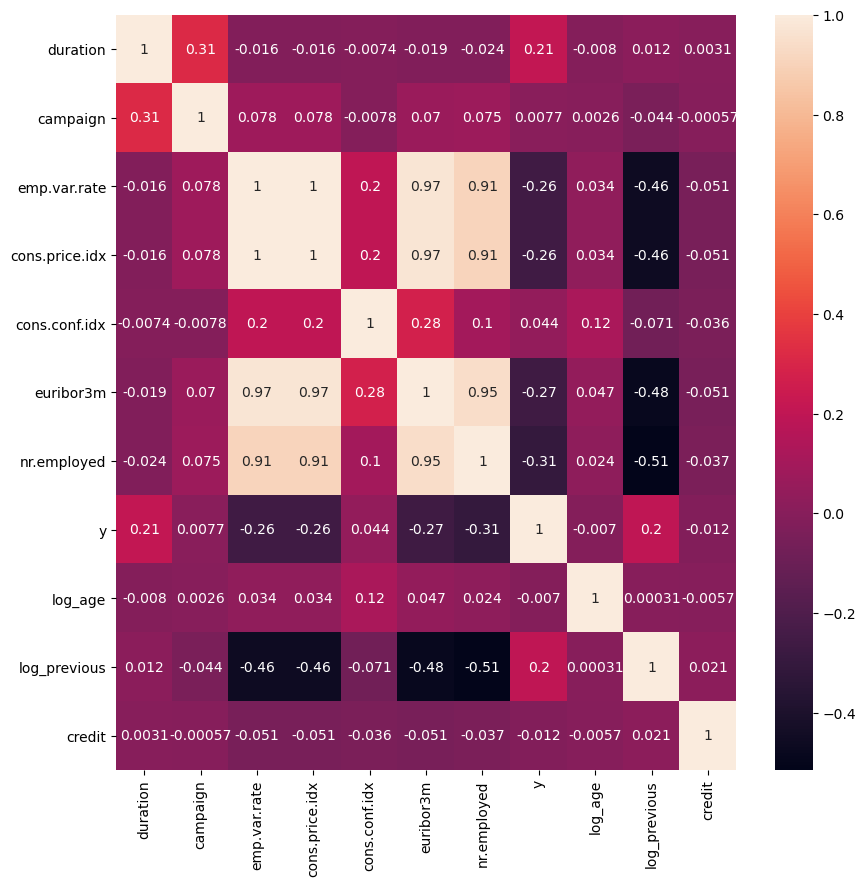

In [16]:
corr = df.corr()
plt.figure(figsize=(10, 10), dpi=100)
sns.heatmap(corr, annot=corr)

## EDA - categorical ##

* Job - I can make the conclusion that there is visibly ***more chance for deposit subscription if clients are unemployed (students, retired or unemployed)***. The percentage of deposit subscriptions is high in these groups (between 20% and 30%). 

* Marital status - There is slightly ***more single people that made deposit***.

* Education-Clients ***with university degrees have a little more percentage of open deposits*** than other group.* Contact -

* People who were contacted by ***cellular during the campaign have put deposits more often****

* Month and day - this may be surprising but people who were contacted in ***December, March, October and September placed deposits more often***. However, there is no visible connection with the target class when it comes to day variable.

* Poutcome - ***if the previous campaign was successful, there is a higher chance of deposit subscription***. Also, if there was a failure of a previous campaign, the chance of a positive deposit subscription is higher than if there was no campaign at all.

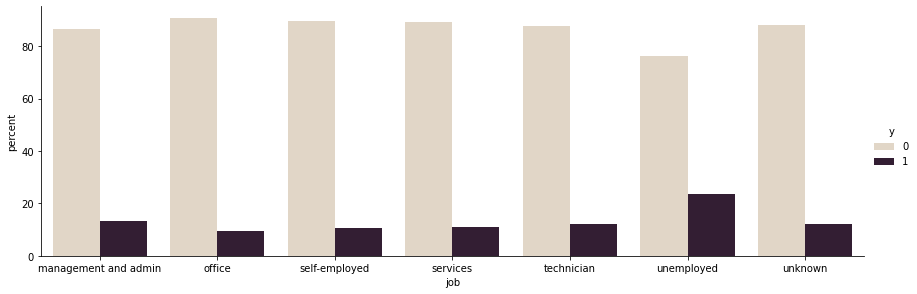

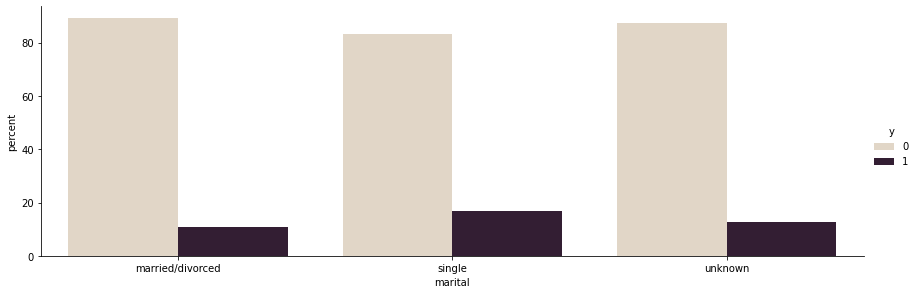

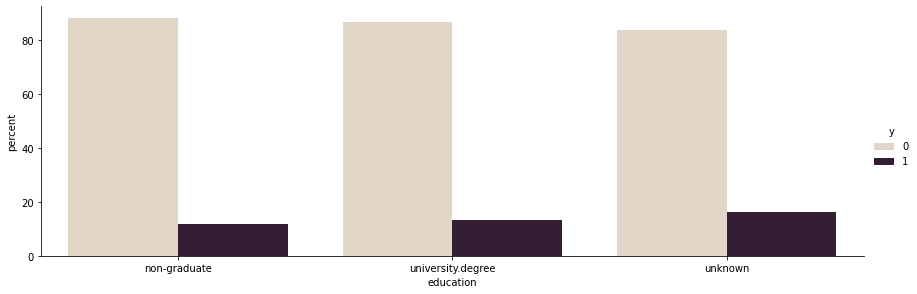

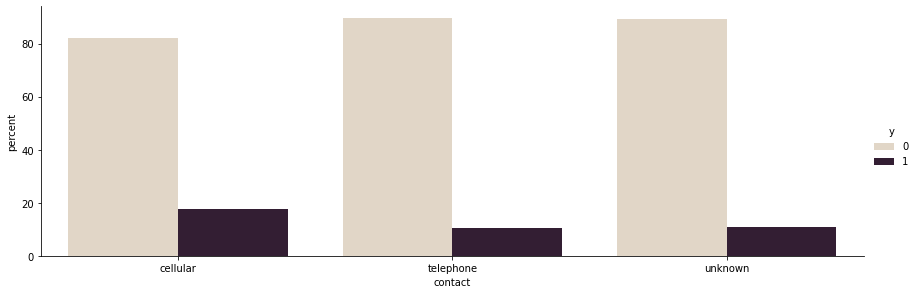

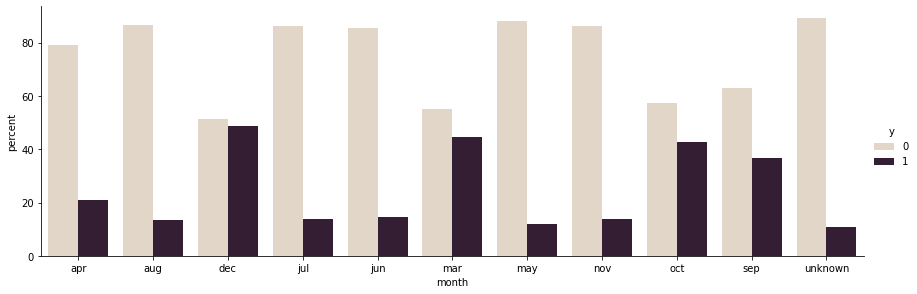

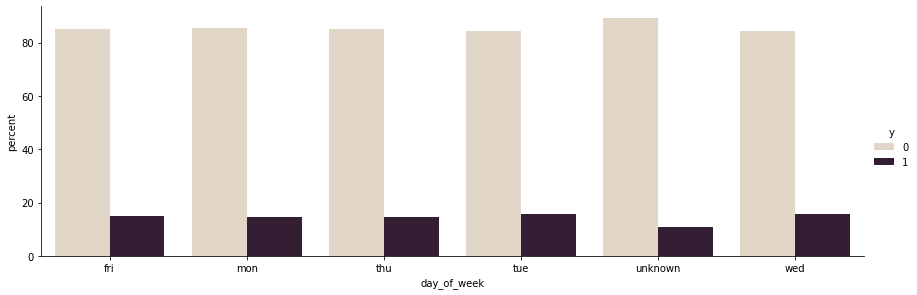

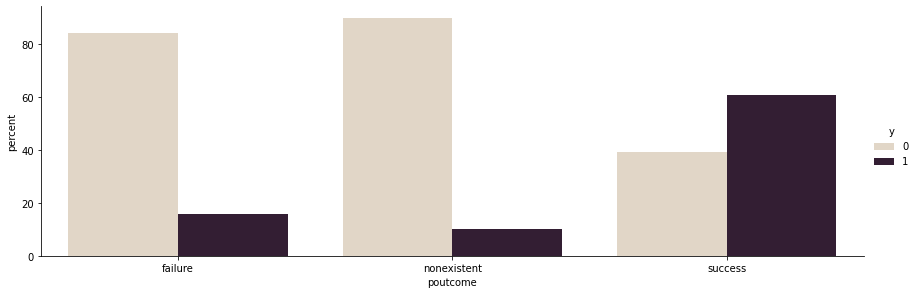

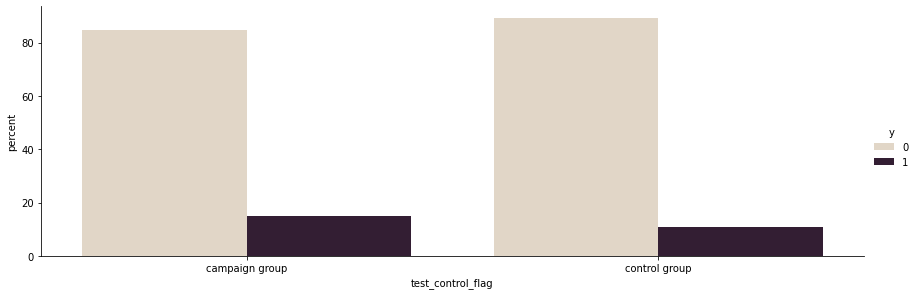

In [17]:
for col_name in df.select_dtypes(include='object').columns:
    x, y = col_name, 'y'
    show_categories_bar_chart(x, y, df)

## Droping features that cannot be used for model creation

As I mentioned before, I can only use features not related to the current campaign (I need features known before the campaign, so the model will be helpful when predicting who we should contact).

In [18]:
df_for_analysis = df.drop(["test_control_flag", "day_of_week", "contact", "month", "day_of_week", "duration", "campaign"], 
                          axis='columns', inplace=False)

# Feature selection #

I use Lasso Regression, which chooses only features having an impact on the target variable. Moreover, it deals with features correlated with each other (by removing one of them). Before Lasso, I used RobustScaler, not StandardScaler, because I have a dataset with outliers.

In [19]:
df_dummies = pd.get_dummies(
    df_for_analysis[df_for_analysis.select_dtypes(include='object').columns],
    drop_first=True)
df_for_analysis = df_for_analysis.drop(columns=df_for_analysis.select_dtypes(
    include='object').columns)
df_for_analysis = pd.merge(df_for_analysis,
                           df_dummies,
                           on=df_for_analysis.index)
df_for_analysis.drop("key_0", axis='columns', inplace=True)
print("Size of dataset after dummy variables: ", len(df_for_analysis.columns))

Size of dataset after dummy variables:  21


In [20]:
scaler = RobustScaler()
X = df_for_analysis.drop("y", axis='columns', inplace=False)
y = df_for_analysis['y']
X_scaled = scaler.fit(X).transform(X)
X_scaled

lasso = Lasso(alpha=0.002)
lasso.fit(X_scaled, y)
FI_lasso = pd.DataFrame({"Feature Importance": lasso.coef_}, index=X.columns)
keep_values = []
for x in FI_lasso.sort_values("Feature Importance", ascending=False):
    if x == True:
        keep_values.append(x)

X = X[FI_lasso[FI_lasso.values != 0].index]

In [21]:
print("Variables left after feature selection:", len(X.columns))
X.columns

Variables left after feature selection: 7


Index(['cons.conf.idx', 'nr.employed', 'credit', 'job_office',
       'job_unemployed', 'marital_single', 'poutcome_success'],
      dtype='object')

# Creating few models #

The ***cost of including in the campaign additional customers (even if they will not place a deposit later) is probably lower than omitting a client that may place a deposit***. According to that, it would be best if I used a recall measure during the training. However, this is not a good metric for training as it may lead to extreme cases when all observations are classified as positive cases. So, I will use AUC as a compromise.

Models are created with below features (chosen by LASSO):
* cons.conf.idx
* nr.employed
* credit
* job_office
* job_unemployed
* marital_single
* poutcome_success

In [22]:
# splitting dataset according to the rule 70%-15%-15%

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=4,
                                                    stratify=y)

X_test, X_validation, y_test, y_validation = train_test_split(X_test,
                                                              y_test,
                                                              test_size=0.5,
                                                              random_state=4,
                                                              stratify=y_test)

scaler = RobustScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_validation_standardized = scaler.transform(X_validation)

In [23]:
# functions used later


def plot_confusion_matrix(cm,
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True values')
    plt.xlabel('Received values')
    plt.tight_layout()


def show_training_results(classifier_name, y_hat_val, y_hat_train):
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    cm = metrics.confusion_matrix(y_validation, y_hat_val)
    plot_confusion_matrix(cm,
                          classes=[0, 1],
                          title="{} Validation".format(classifier_name))

    plt.subplot(1, 2, 2)
    cm = metrics.confusion_matrix(y_train, y_hat_train)
    plot_confusion_matrix(cm,
                          classes=[0, 1],
                          title="{} Train".format(classifier_name))

    plt.show()

    print("Accuracy from {} - validation: ".format(classifier_name),
          round(metrics.accuracy_score(y_validation, y_hat_val), 2))
    print("Recall from {} - validation: ".format(classifier_name),
          round(metrics.recall_score(y_validation, y_hat_val), 2))
    print("AUC from {} - validation: ".format(classifier_name),
          round(metrics.roc_auc_score(y_validation, y_hat_val), 2))


def show_ROC_plot(label, pos_probs, y_test):
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    fpr, tpr, _ = metrics.roc_curve(y_test, pos_probs)
    plt.plot(fpr, tpr, marker='.', label=label)
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='Perfect')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title("ROC curve")
    plt.show()


def show_lift_plot(pos_probs, y_test):
    skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
    plt.show()

## Logistic Regression ##


The first algorithm used for classification was Logistic Regression. I used standardized datasets for that. The ***weights had to be actualized for imbalanced data***. I have also used ***L2 Regularization***, so the model would not increase its complexity too much. I have also tried **two values of prediction threshold**.

Best: 0.726136 using {'C': 1}


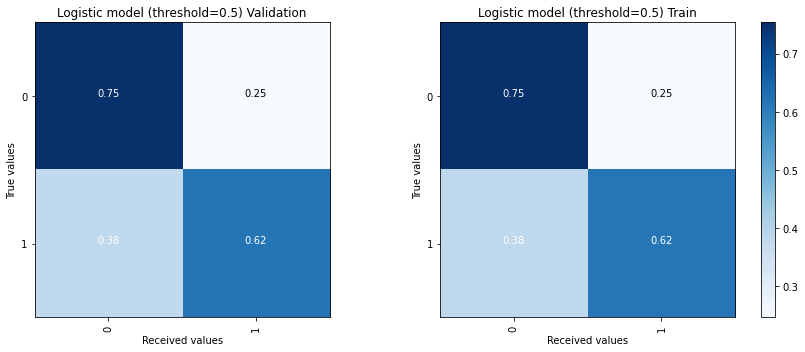

Accuracy from Logistic model (threshold=0.5) - validation:  0.74
Recall from Logistic model (threshold=0.5) - validation:  0.62
AUC from Logistic model (threshold=0.5) - validation:  0.69


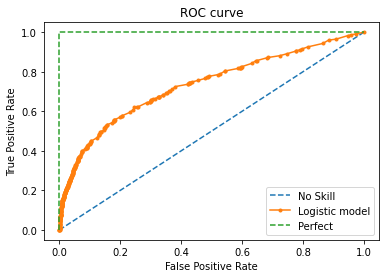

In [24]:
model = LogisticRegression(class_weight="balanced", penalty='l2')

param_grid = {'C': [0.001, 0.01, 0.05, 0.2, 1, 3]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

logistic = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        cv=cv,
                        scoring='roc_auc')

logistic = logistic.fit(X_train_standardized, y_train)

probas_val = logistic.predict_proba(X_validation_standardized)[:, 1]

print("Best: %f using %s" % (logistic.best_score_, logistic.best_params_))

y_hat_val = (probas_val >= 0.5).astype(bool)
y_hat_train = (logistic.predict_proba(X_train_standardized)[:, 1] >=
               0.5).astype(bool)

show_training_results("Logistic model (threshold=0.5)", y_hat_val, y_hat_train)
show_ROC_plot("Logistic model", probas_val, y_validation)

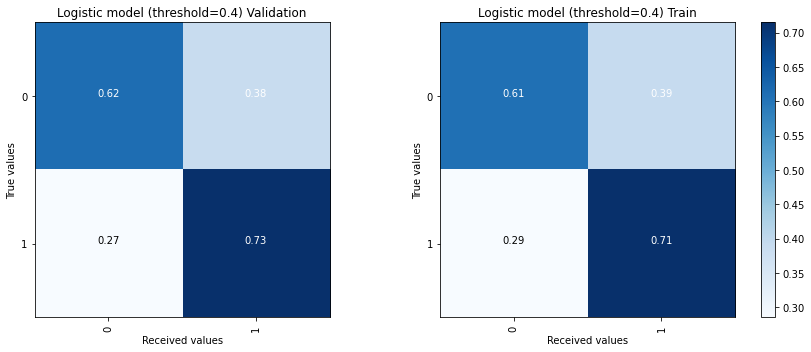

Accuracy from Logistic model (threshold=0.4) - validation:  0.63
Recall from Logistic model (threshold=0.4) - validation:  0.73
AUC from Logistic model (threshold=0.4) - validation:  0.67


In [25]:
y_hat_val = (probas_val >= 0.4).astype(bool)
y_hat_train = (logistic.predict_proba(X_train_standardized)[:, 1] >= 0.4).astype(bool)

show_training_results("Logistic model (threshold=0.4)", y_hat_val, y_hat_train)

## Decision Tree ##

The second algorithm used for classification was Decision Tree ***checked for two splitting criteria and various maximal tree depths, number of min samples in leaf and split***. I have also tried **two values of prediction threshold**.

Best: 0.745233 using {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 10}


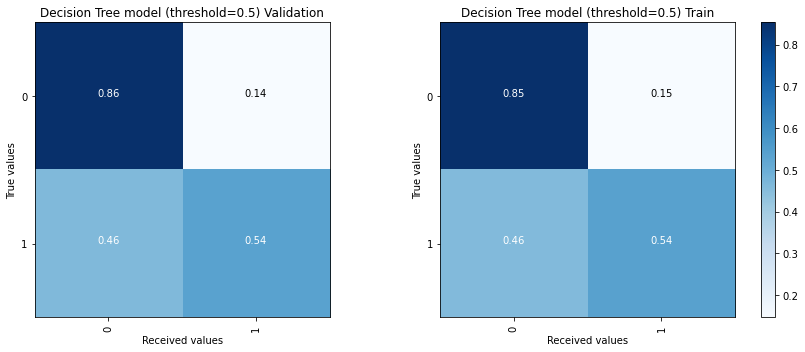

Accuracy from Decision Tree model (threshold=0.5) - validation:  0.82
Recall from Decision Tree model (threshold=0.5) - validation:  0.54
AUC from Decision Tree model (threshold=0.5) - validation:  0.7


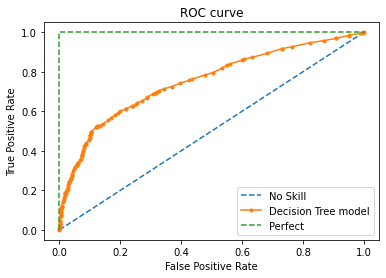

In [26]:
model = DecisionTreeClassifier(class_weight="balanced")

param_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': [4, 6, 7, 8, 9, 12],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [10, 15]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

tree = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=cv,
                    scoring='roc_auc')

tree.fit(X_train, y_train)
print("Best: %f using %s" % (tree.best_score_, tree.best_params_))

tree = tree.best_estimator_

probas_val = tree.predict_proba(X_validation)[:, 1]

y_hat_val = (probas_val >= 0.5).astype(bool)
y_hat_train = (tree.predict_proba(X_train)[:, 1] >= 0.5).astype(bool)

show_training_results("Decision Tree model (threshold=0.5)", y_hat_val,
                      y_hat_train)
show_ROC_plot("Decision Tree model", probas_val, y_validation)

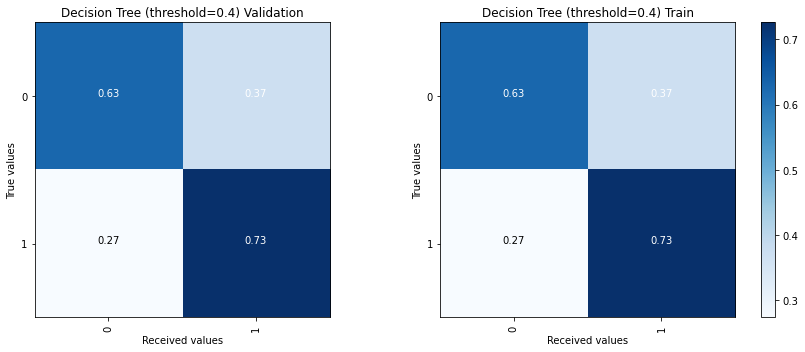

Accuracy from Decision Tree (threshold=0.4) - validation:  0.64
Recall from Decision Tree (threshold=0.4) - validation:  0.73
AUC from Decision Tree (threshold=0.4) - validation:  0.68


In [27]:
y_hat_val = (probas_val >= 0.4).astype(bool)
y_hat_train = (tree.predict_proba(X_train)[:, 1] >= 0.4).astype(bool)

show_training_results("Decision Tree (threshold=0.4)", y_hat_val, y_hat_train)

# Can we improve the campaign? #

As a final model, I chose the decision tree model with a 0.4 threshold (observation with a probability from the model higher than 0.4 would be considered for the campaign). There are a few factors in favour of this model:

- It has good recall (so the ability to discover the positive class by the model) of 73% on validation data and I assume that it is more costly to omit a person who may place a deposit.

- It still maintains an accuracy of 64% and an auc of 68% on validation data.

Of course, the results could be better. It may also be beneficial to refrain from joining so many categories, as I did in point 4.3 (maybe this was too big a loss in information). More machine learning models and more powerful models (like random forest or xgboost) could be considered while choosing the best models. However, such an analysis would require more time as the time to adjust its parameters is longer.

In [28]:
final_model = tree
final_threshold = 0.4

In [29]:
X_train

,cons.conf.idx,nr.employed,credit,job_office,job_unemployed,marital_single,poutcome_success
9071,-36.1,5228.1,False,0,0,0,0
8273,-36.1,5228.1,False,0,0,0,0
39276,-29.8,5017.5,True,0,1,0,1
15994,-39.8,4991.6,True,0,0,0,0
471,-36.4,5191.0,False,0,0,1,0
...,...,...,...,...,...,...,...
18700,-36.4,5191.0,True,0,0,0,0
12726,-46.2,5099.1,True,0,0,0,0
24915,-42.7,5228.1,True,1,0,0,0
33399,-47.1,5099.1,False,0,1,1,0


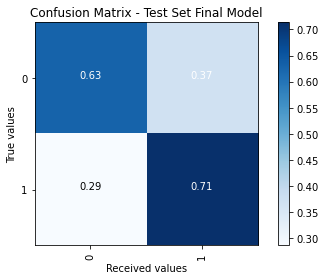

Accuracy for Test Set:  0.64
Recall for Test Set:  0.71
AUC for Test Set:  0.67
precision for Test Set:  0.22


In [31]:
probas_test = final_model.predict_proba(X_test)[:, 1]

y_hat_test = (probas_test >= final_threshold).astype(bool)

cm = metrics.confusion_matrix(y_test, y_hat_test)
plot_confusion_matrix(cm,
                      classes=[0, 1],
                      title='Confusion Matrix - Test Set Final Model')
plt.show()

print("Accuracy for Test Set: ",
      round(metrics.accuracy_score(y_test, y_hat_test), 2))
print("Recall for Test Set: ",
      round(metrics.recall_score(y_test, y_hat_test), 2))
print("AUC for Test Set: ", round(metrics.roc_auc_score(y_test, y_hat_test), 2))
print("precision for Test Set: ",
      round(metrics.precision_score(y_test, y_hat_test), 2))

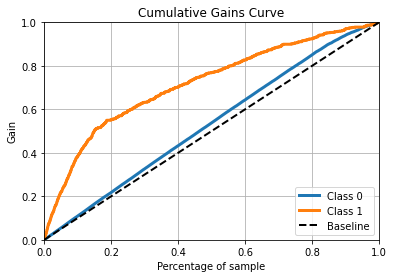

In [32]:
skplt.metrics.plot_cumulative_gain(y_test, final_model.predict_proba(X_test))
plt.show()

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

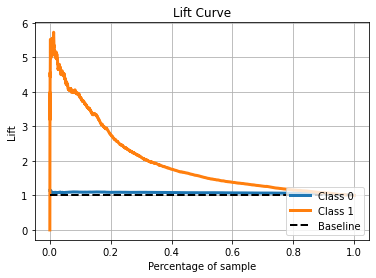

In [33]:
skplt.metrics.plot_lift_curve(y_test, final_model.predict_proba(X_test))

In [73]:
print(
    "Taking 40% of clients from dataset into campaign group based on the model, so {} people, the predicted number of those who placed the deposit would be {}. "
    .format(int(0.4 * len(df)), int(0.7 * int(0.4 * len(df)))))

Taking 40% of clients from dataset into campaign group based on the model, so 16475 people, the predicted number of those who placed the deposit would be 11532. 


To assess the impact of the model on the campaign, the LIFT curve and Cumulative Gains curve were used on the test dataset.

* From the LIFT curve, it can be seen that a model **if using 10% of the model's best predictions, the obtained model is 4 times better than choosing campaign respondents at random**

* It can be seen that ***selecting the top 20% of the leads ranked as most likely to respond to a marketing offer will contain about 55–57% of the actual responders (people who will place the deposits)***. So let's say that we contact 20% of people in our database but using a created model (so contacting people for whom the model returned the highest probabilities). We should expect that 55-57% of them will actually place the deposit in the bank. To reach this score without using a machine learning model, it would be necessary to contact 55-57% of the people in the database. At the same time, **according to the LIFT chart, the model is then 2.7 times better than choosing campaign respondents at random.** 
* **contacting 40% of the most likely respondents should result in approximately 70% of them placing the deposit**. Model is then 1.75 times better than the baseline. 


**To sum up, according to the model, contacting 40% of clients (so the percentage that was originally included in the campaign) that are most likely to respond based on the model, should result in approximately 70% of them placing the deposit. At the beginning, I pointed out that without the model, approximately 15% of the respondents of the campaign placed the deposits, and 10% of clients not included in the campaign did the same. So the improvement of the campaign's results should be significant.**

Taking 40% of clients from the dataset into a campaign group based on the model would mean 16475 people. The predicted number of those who placed the deposit would be 11532. This is two times as much as the number of those who placed the deposits in the entire dataset (y = 'yes' for 5168 clients).